# Imports and Preprocessing

In [3]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error
from math import sqrt
from random import randint
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Dropout
from keras.callbacks import EarlyStopping
from keras import initializers
from matplotlib import pyplot
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.impute import SimpleImputer
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
# import plotly.offline as py
# import plotly.graph_objs as go
# py.init_notebook_mode(connected=True)
%matplotlib inline

Import test data

In [70]:
data = pd.read_csv('/Users/yuhaoli/code/HowardLiYH/Volatility-prediction/datasets/raw/raw_data.csv')
data

,scrape_time,lastUpdateId,bids_price_01,bids_size_01,bids_price_02,bids_size_02,ask_price_01,ask_size_01,ask_price_02,ask_size_02
0,2023-03-27 10:30:36,17668615506,27905.28,12.59899,27904.92,0.01921,27905.29,1.58571,27905.30,1.02708
1,2023-03-27 10:30:41,17668615812,27905.28,13.05932,27905.15,0.00208,27905.29,3.29816,27905.30,0.00252
2,2023-03-27 10:30:45,17668616793,27909.14,10.13004,27909.03,0.09094,27909.15,5.28372,27909.94,0.09800
3,2023-03-27 10:30:50,17668617069,27909.14,9.63960,27909.03,0.09094,27909.15,5.83321,27909.16,0.00401
4,2023-03-27 10:30:54,17668617292,27909.14,0.22453,27908.60,0.00559,27909.15,6.31910,27909.16,0.00401
...,...,...,...,...,...,...,...,...,...,...
7258,2023-03-27 19:54:46,17675595465,27071.21,3.93922,27071.20,0.00232,27071.22,3.04686,27071.26,0.70701
7259,2023-03-27 19:54:51,17675595763,27071.21,1.05540,27071.20,0.00232,27071.22,5.07080,27071.32,0.69941
7260,2023-03-27 19:54:56,17675596986,27067.00,0.40343,27066.84,0.38190,27067.01,7.31261,27067.05,0.30726
7261,2023-03-27 19:55:00,17675598589,27059.43,1.50309,27058.51,0.09800,27059.44,4.31640,27060.11,0.55458


In [71]:
data.isnull().values.any()

False

In [72]:
data['WAP'] = (data['bids_price_01']*data['bids_size_01']
               +data['bids_price_02']*data['bids_size_02']
               +data['ask_price_01']*data['ask_size_01']
               +data['ask_price_02']*data['ask_size_02'])/(data['bids_size_01']+
                                         data['bids_size_02']+
                                         data['ask_size_01']+
                                         data['ask_size_02'])

data['spread'] = ((data['ask_price_01']/data['bids_price_01']) - 1)

In [73]:
def log_price(list_stock_prices):
    return np.log(list_stock_prices)

data.insert(0, 'log_price', log_price(data['WAP']))

data['log_returns'] = data.log_price.diff()

In [74]:
def realized_volatility(data):
    list_vol = []
    i = 0
    for i in data.index:
        x = np.std(data.log_returns.iloc[:i])
        i += 1
        list_vol.append(x)
    
    return list_vol
data['realized_volatility'] = realized_volatility(data)
data['volatility_t+1'] = data['realized_volatility'].shift(-1)
data

,log_price,scrape_time,lastUpdateId,bids_price_01,bids_size_01,bids_price_02,bids_size_02,ask_price_01,ask_size_01,ask_price_02,ask_size_02,WAP,spread,log_returns,realized_volatility,volatility_t+1
0,10.236571,2023-03-27 10:30:36,17668615506,27905.28,12.59899,27904.92,0.01921,27905.29,1.58571,27905.30,1.02708,27905.281936,3.583551e-07,NaN,NaN,NaN
1,10.236571,2023-03-27 10:30:41,17668615812,27905.28,13.05932,27905.15,0.00208,27905.29,3.29816,27905.30,0.00252,27905.282002,3.583551e-07,2.385111e-09,NaN,0.000000
2,10.236710,2023-03-27 10:30:45,17668616793,27909.14,10.13004,27909.03,0.09094,27909.15,5.28372,27909.94,0.09800,27909.147770,3.583056e-07,1.385222e-04,0.000000,0.000069
3,10.236710,2023-03-27 10:30:50,17668617069,27909.14,9.63960,27909.03,0.09094,27909.15,5.83321,27909.16,0.00401,27909.143110,3.583056e-07,-1.669880e-07,0.000069,0.000065
4,10.236710,2023-03-27 10:30:54,17668617292,27909.14,0.22453,27908.60,0.00559,27909.15,6.31910,27909.16,0.00401,27909.149194,3.583056e-07,2.180208e-07,0.000065,0.000060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7258,10.206226,2023-03-27 19:54:46,17675595465,27071.21,3.93922,27071.20,0.00232,27071.22,3.04686,27071.26,0.70701,27071.218550,3.693961e-07,1.207422e-07,0.000274,0.000274
7259,10.206227,2023-03-27 19:54:51,17675595763,27071.21,1.05540,27071.20,0.00232,27071.22,5.07080,27071.32,0.69941,27071.228691,3.693961e-07,3.745986e-07,0.000274,0.000274
7260,10.206071,2023-03-27 19:54:56,17675596986,27067.00,0.40343,27066.84,0.38190,27067.01,7.31261,27067.05,0.30726,27067.003258,3.694536e-07,-1.560979e-04,0.000274,0.000274
7261,10.205793,2023-03-27 19:55:00,17675598589,27059.43,1.50309,27058.51,0.09800,27059.44,4.31640,27060.11,0.55458,27059.481007,3.695569e-07,-2.779509e-04,0.000274,0.000274


In [75]:
imputer = SimpleImputer(strategy="constant", fill_value = 0) # Instantiate a SimpleImputer object with your strategy of choice

imputer.fit(data[['volatility_t+1']]) # Call the "fit" method on the object

data['volatility_t+1'] = imputer.transform(data[['volatility_t+1']]) # Call the "transform" method on the object

imputer.statistics_ # The mean is stored in the transformer's memory

array([0.])

In [76]:
# data.drop(['realized_volatility', 'WAP', 'spread', 'log_returns', 'log_price', 'lastUpdateId'], axis = 1, inplace = True) 

In [20]:
data = data.set_index(['scrape_time'])

In [77]:
## Elimate the outlier 0 value on Vol + 1
data = data.iloc[2:-1,:]

In [79]:
data.drop(['scrape_time', 'lastUpdateId', 'bids_price_01', 'bids_size_01', 'bids_price_02', 'bids_size_02', 'ask_price_01', 'ask_size_01', 'ask_price_02','ask_size_02'], axis = 1, inplace = True) 

In [82]:
data = data.iloc[1:,:]

In [83]:
data

,log_price,WAP,spread,log_returns,realized_volatility,volatility_t+1
3,10.236710,27909.143110,3.583056e-07,-1.669880e-07,0.000069,0.000065
4,10.236710,27909.149194,3.583056e-07,2.180208e-07,0.000065,0.000060
5,10.236690,27908.593522,3.583125e-07,-1.991024e-05,0.000060,0.000058
6,10.236690,27908.593799,3.583125e-07,9.931485e-09,0.000058,0.000054
7,10.236690,27908.592744,3.583125e-07,-3.780637e-08,0.000054,0.000050
...,...,...,...,...,...,...
7257,10.206226,27071.215281,3.693961e-07,3.083081e-08,0.000274,0.000274
7258,10.206226,27071.218550,3.693961e-07,1.207422e-07,0.000274,0.000274
7259,10.206227,27071.228691,3.693961e-07,3.745986e-07,0.000274,0.000274
7260,10.206071,27067.003258,3.694536e-07,-1.560979e-04,0.000274,0.000274


In [28]:
# #sum of all bid quantities
# data['bid depth'] = data[['bids_size_01', 'bids_size_02']].sum(axis=1)
      

# #sum of all bid quantities
# data['ask depth'] = data[['ask_size_01', 'ask_size_02']].sum(axis=1)

# #Order Flow Imbalance (OFI) 
# #relative quantities of bids vs asks
# #full depth (approx 20 levels) OFI
# data['FDOFI'] = (data['bid depth']-data['ask depth'])/(data['bid depth']+data['ask depth'])

# data

In [118]:
X = data.drop(['volatility_t+1','realized_volatility'], axis=1)
y = np.expand_dims(data['volatility_t+1'].values, 1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [120]:
scaler = MinMaxScaler().fit(X)
X_scaled = scaler.transform(X)
X_scaled.shape

(7259, 4)

# Multivariate LSTM 

In [121]:
def convert2matrix(X_arr,Y_arr, look_back=1):
    X, Y =[], []
     #iterating thorough the data with window as look back
    for i in range(len(X_arr)-look_back):
        d=i+look_back 
        # extracting the X as features and target of n days and Y as   target at (n+1)th day
        X.append(np.hstack((X_arr[i:d],Y_arr[i:d])))
        Y.append(Y_arr[d])
        
    return np.array(X), np.array(Y)

In [122]:
# transformer = Normalizer().fit(X)
# n_X = transformer.transform(X)
# n_X.shape

In [123]:
X.shape, y.shape

((7259, 4), (7259, 1))

In [124]:
X_new, y_new = convert2matrix(X_scaled, y, 10)
X_new.shape, y_new.shape

((7249, 10, 5), (7249, 1))

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2, shuffle=False)

In [126]:
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(X_new.shape[1], X_new.shape[2])))
model.add(LSTM(128, return_sequences=False))
# model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(1))

# compile and fit the model
model.compile(loss='mse', optimizer=Adam(0.001), metrics=['mape'])

In [127]:
# pipe = Pipeline([('Imputer', SimpleImputer(strategy = 'mean')),
#             ('scaler', MinMaxScaler()),
#             # 'model', ARIMA(order=(2, 1, 3), trend='t')])
#             'model', model])
history = model.fit(X_train, y_train, epochs=100, batch_size=8, shuffle=True,
                    validation_split=0.1,
                    callbacks = 
                    [EarlyStopping(patience=20, verbose=1, restore_best_weights=True)])

Epoch 1/100
653/653 [==============================] - 8s 10ms/step - loss: 2.4074e-04 - mape: 3442.8367 - val_loss: 1.0264e-08 - val_mape: 22.3773
Epoch 2/100
653/653 [==============================] - 6s 9ms/step - loss: 1.1771e-06 - mape: 577.2764 - val_loss: 6.2986e-09 - val_mape: 19.5791
Epoch 3/100
653/653 [==============================] - 5s 8ms/step - loss: 2.3122e-06 - mape: 849.0008 - val_loss: 1.1316e-07 - val_mape: 108.9446
Epoch 4/100
653/653 [==============================] - 5s 8ms/step - loss: 5.9513e-06 - mape: 1412.3853 - val_loss: 5.7903e-08 - val_mape: 77.2126
Epoch 5/100
653/653 [==============================] - 6s 9ms/step - loss: 4.5620e-06 - mape: 1232.1954 - val_loss: 2.1362e-06 - val_mape: 484.1628
Epoch 6/100
653/653 [==============================] - 5s 8ms/step - loss: 6.6793e-06 - mape: 1560.7834 - val_loss: 5.6219e-07 - val_mape: 246.4014
Epoch 7/100
653/653 [==============================] - 5s 8ms/step - loss: 2.7999e-06 - mape: 947.0333 - val_loss: 1

BaseLine

46/46 [==============================] - 0s 5ms/step


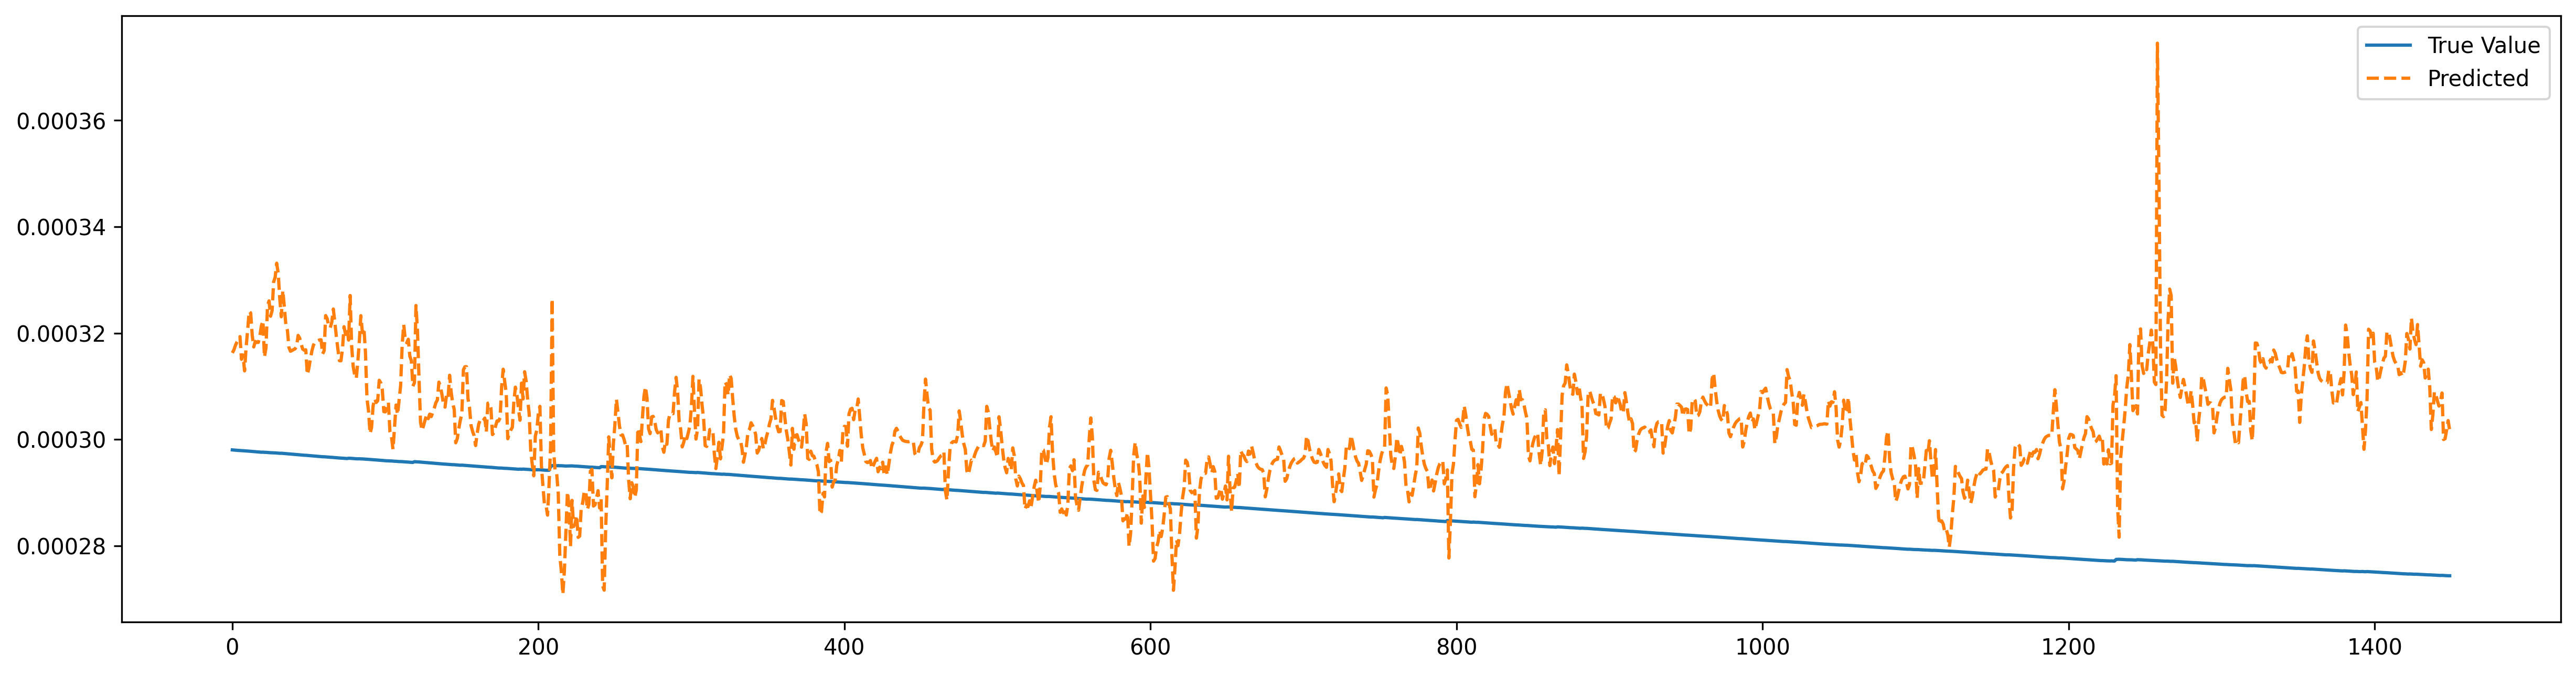

In [128]:
from sklearn.metrics import mean_absolute_error
pred = model.predict(X_test)
plt.figure(figsize=(20,5),dpi=300)
plt.plot(y_test,label='True Value')
plt.plot(pred,linestyle='--', label = 'Predicted')
plt.legend()
plt.show()

In [129]:
tb_mae = np.mean(np.abs(y_test - pred))
tb_mae

1.656173907599473e-05

In [130]:
pd.DataFrame(pred).value_counts()

0.000298    2
0.000271    1
0.000305    1
0.000305    1
0.000305    1
           ..
0.000297    1
0.000297    1
0.000297    1
0.000297    1
0.000375    1
Length: 1449, dtype: int64

182/182 [==============================] - 1s 5ms/step


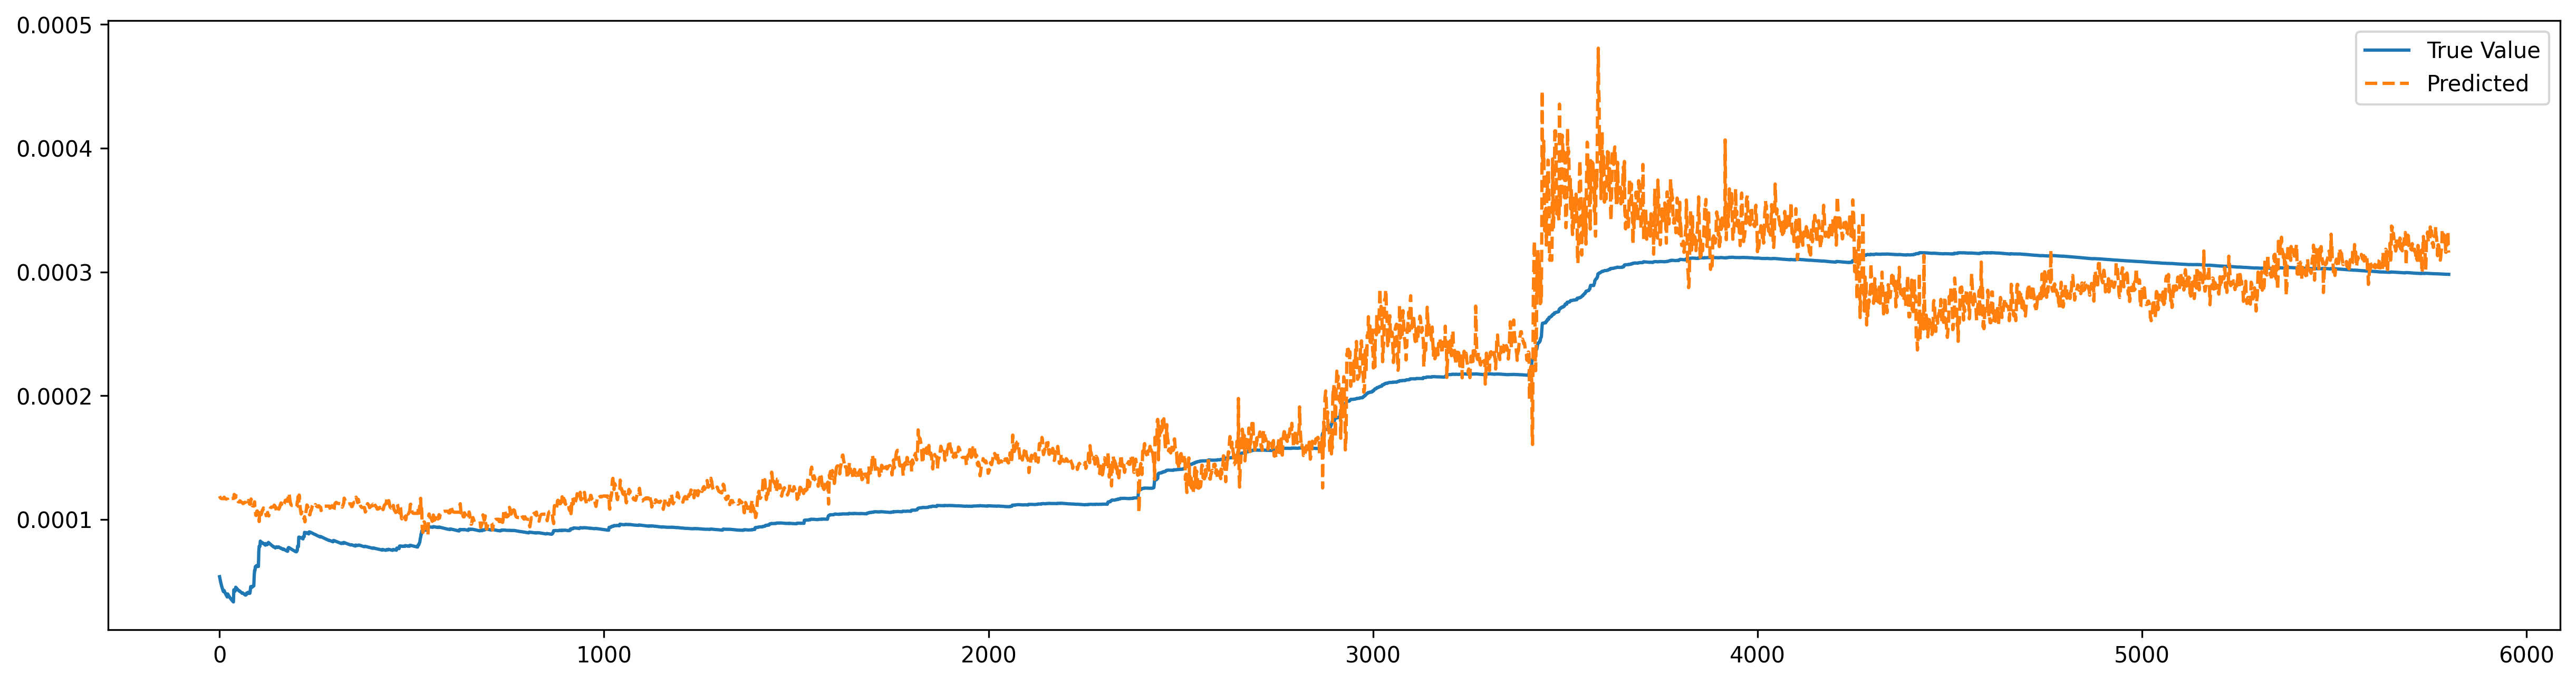

In [131]:
pred = model.predict(X_train)
plt.figure(figsize=(20,5),dpi=300)
plt.plot(y_train,label='True Value')
plt.plot(pred,linestyle='--', label = 'Predicted')
plt.legend()
plt.show()

In [132]:
model.evaluate(X_test, y_test)

46/46 [==============================] - 0s 5ms/step - loss: 3.9864e-10 - mape: 5.8542


[3.986384278231725e-10, 5.854243755340576]

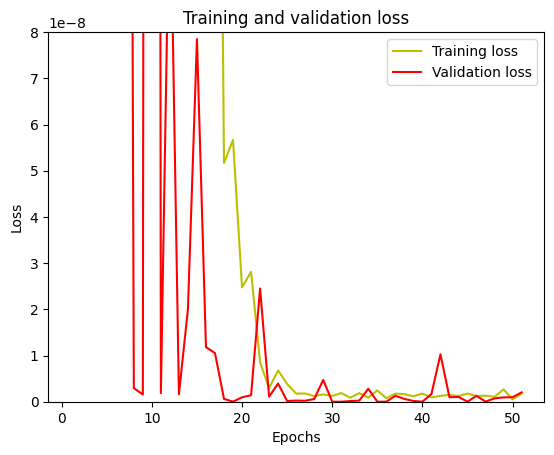

In [114]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0, 0.00000008)
plt.show()

In [133]:
# pred = model.predict(X_test)
# plt.figure(figsize=(20,5),dpi=300)
# plt.plot(y_total,label='True Value')
# plt.plot(pred,linestyle='--', label = 'Predicted')
# plt.legend()
# plt.show()

In [115]:
y_test

array([[0.00029802],
       [0.00029799],
       [0.00029797],
       ...,
       [0.00027436],
       [0.00027434],
       [0.00027434]])

In [72]:
y_train.shape

(5802, 1)

In [74]:
y_total = np.concatenate((y_train, y_test), axis=None)

(7253,)

# 0329 Sample with 20 bid/ask

In [8]:
data1 = pd.read_csv('/Users/yuhaoli/code/HowardLiYH/Volatility-prediction/datasets/raw/data0329.csv')
data1

,bp_1,bz_1,bp_2,bz_2,bp_3,bz_3,bp_4,bz_4,bp_5,bz_5,...,ap_17,az_17,ap_18,az_18,ap_19,az_19,ap_20,az_20,scrape_time,lastUpdateId
0,27215.98,3.62823,27215.71,0.09094,27215.15,0.06106,27215.14,0.10176,27213.06,0.11000,...,27220.22,0.18378,27220.24,0.18378,27220.40,0.38577,27220.87,0.73017,2023-03-28 19:33:30,17688482161
1,27219.01,2.49441,27218.96,0.40455,27218.95,0.81592,27218.94,0.56887,27218.86,0.51754,...,27221.64,0.05013,27221.79,0.03673,27222.27,0.04246,27222.44,0.03673,2023-03-28 19:33:24,17688480766
2,27219.01,0.53591,27218.72,0.41551,27218.71,0.07000,27218.40,0.00671,27218.36,0.57475,...,27223.09,0.22057,27223.10,0.36755,27223.24,0.46670,27223.25,0.00367,2023-03-28 19:33:19,17688480114
3,27223.23,6.40427,27221.59,1.00260,27221.39,0.03674,27221.36,1.10536,27221.34,1.10536,...,27227.34,0.18374,27227.92,1.06032,27228.39,1.21947,27228.40,2.03245,2023-03-28 19:33:36,17688483548
4,27223.23,0.48052,27222.67,0.48829,27222.40,0.09468,27222.29,0.57712,27222.22,0.00921,...,27227.34,0.36748,27228.05,0.03622,27228.07,1.01425,27228.08,0.78360,2023-03-28 19:33:07,17688478201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2639,26930.46,5.33370,26930.45,0.00316,26930.37,0.03715,26930.31,0.61962,26930.30,0.02100,...,26934.48,0.00076,26934.51,0.18575,26934.55,0.64260,26934.56,1.07101,2023-03-28 09:57:44,17681597926
2640,26930.46,5.77308,26930.37,0.03715,26930.31,0.61962,26930.30,0.02100,26930.28,1.10540,...,26934.57,0.00081,26934.67,0.00282,26934.86,0.01500,26935.00,0.10855,2023-03-28 09:57:38,17681597775
2641,26931.30,8.17244,26931.23,1.10536,26931.22,0.09094,26931.11,0.58155,26931.02,1.10536,...,26933.06,0.70284,26933.33,0.01277,26933.61,0.76224,26933.81,0.58400,2023-03-28 09:56:30,17681587296
2642,26931.30,8.64483,26931.24,0.90942,26931.23,1.10536,26931.02,1.10536,26931.01,0.90942,...,26933.95,1.00681,26934.09,0.00129,26934.29,0.01500,26934.30,0.00076,2023-03-28 09:56:24,17681586783


In [137]:
data.isnull().values.any()

False

In [138]:
# Weighted Average Price 
data['WAP'] = (data['bp_1']*data['bz_1']
               +data['bp_2']*data['bz_2']
               +data['ap_1']*data['az_1']
               +data['ap_2']*data['az_2'])/(data['bz_1']+
                                         data['bz_2']+
                                         data['az_1']+
                                         data['az_2'])

In [139]:
## Spread
data['spread'] = ((data['ap_1']/data['bp_1']) - 1)

In [140]:
## Log price

def log_price(list_stock_prices):
    return np.log(list_stock_prices)

data.insert(0, 'log_price', log_price(data['WAP']))

data['log_returns'] = data.log_price.diff()

In [141]:
## Realized Volatility
def realized_volatility():
    list_vol = []
    i = 0
    for i in data.index:
        x = np.std(data.log_returns.iloc[:i])
        i += 1
        list_vol.append(x)
    
    return list_vol

data['realized_volatility'] = realized_volatility()

In [142]:
## Previous volatility

data['volatility_t+1'] = data['realized_volatility'].shift(-1)

In [144]:
data.drop(['lastUpdateId'], axis = 1, inplace = True) 

In [146]:
data.drop(['scrape_time'], axis = 1, inplace = True)

In [153]:
data = data.iloc[3:-1,:]

In [154]:
y = np.expand_dims(data['realized_volatility'].values, 1)

In [156]:
X = data.drop('realized_volatility', axis=1)

In [157]:
scaler = MinMaxScaler().fit(X)
X_scaled = scaler.transform(X)
X_scaled.shape

(2640, 85)

In [159]:
y.shape

(2640, 1)

In [160]:
def convert2matrix(X_arr,Y_arr, look_back=1):
    X, Y =[], []
     #iterating thorough the data with window as look back
    for i in range(len(X_arr)-look_back):
        d=i+look_back 
        # extracting the X as features and target of n days and Y as   target at (n+1)th day
        X.append(np.hstack((X_arr[i:d],Y_arr[i:d])))
        Y.append(Y_arr[d])
        
    return np.array(X), np.array(Y)

In [162]:
X.shape, y.shape

((2640, 85), (2640, 1))

In [163]:
X_new, y_new = convert2matrix(X_scaled, y, 10)
X_new.shape, y_new.shape

((2630, 10, 86), (2630, 1))

In [164]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2, shuffle=False)

In [190]:
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(X_new.shape[1], X_new.shape[2])))
model.add(LSTM(128, return_sequences=False))
# model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(1))

# compile and fit the model
model.compile(loss='mse', optimizer=Adam(0.0001), metrics=['mape'])

In [191]:
# pipe = Pipeline([('Imputer', SimpleImputer(strategy = 'mean')),
#             ('scaler', MinMaxScaler()),
#             # 'model', ARIMA(order=(2, 1, 3), trend='t')])
#             'model', model])
history = model.fit(X_train, y_train, epochs=500, batch_size=8, shuffle=True,
                    validation_split=0.1,
                    callbacks = 
                    [EarlyStopping(patience=20, verbose=1, restore_best_weights=True)])

Epoch 1/500
237/237 [==============================] - 4s 11ms/step - loss: 8.3022e-04 - mape: 4413.0068 - val_loss: 3.1408e-05 - val_mape: 375.2622
Epoch 2/500
237/237 [==============================] - 2s 9ms/step - loss: 1.8719e-04 - mape: 2228.7891 - val_loss: 4.5240e-05 - val_mape: 469.0457
Epoch 3/500
237/237 [==============================] - 2s 9ms/step - loss: 1.3631e-04 - mape: 1754.7212 - val_loss: 7.3038e-06 - val_mape: 195.9395
Epoch 4/500
237/237 [==============================] - 2s 9ms/step - loss: 9.4043e-05 - mape: 1498.5952 - val_loss: 6.3641e-06 - val_mape: 178.5663
Epoch 5/500
237/237 [==============================] - 2s 9ms/step - loss: 6.6161e-05 - mape: 1173.1398 - val_loss: 2.4175e-05 - val_mape: 373.8828
Epoch 6/500
237/237 [==============================] - 2s 9ms/step - loss: 5.6400e-05 - mape: 1068.2980 - val_loss: 1.7573e-05 - val_mape: 314.7176
Epoch 7/500
237/237 [==============================] - 2s 9ms/step - loss: 5.8261e-05 - mape: 1146.0438 - val_l

237/237 [==============================] - 2s 9ms/step - loss: 1.3307e-08 - mape: 17.3969 - val_loss: 3.4815e-09 - val_mape: 4.5172
Epoch 113/500
237/237 [==============================] - 2s 9ms/step - loss: 1.1215e-08 - mape: 15.4214 - val_loss: 2.4495e-09 - val_mape: 3.5910
Epoch 114/500
237/237 [==============================] - 2s 9ms/step - loss: 9.8225e-09 - mape: 15.4555 - val_loss: 3.2831e-09 - val_mape: 3.9137
Epoch 115/500
237/237 [==============================] - 2s 9ms/step - loss: 9.4735e-09 - mape: 14.2705 - val_loss: 1.1985e-08 - val_mape: 8.7633
Epoch 116/500
237/237 [==============================] - 2s 9ms/step - loss: 1.1465e-08 - mape: 15.9409 - val_loss: 5.5135e-09 - val_mape: 5.7887
Epoch 117/500
237/237 [==============================] - 2s 9ms/step - loss: 9.3539e-09 - mape: 15.4267 - val_loss: 8.0433e-09 - val_mape: 7.3119
Epoch 118/500
237/237 [==============================] - 2s 9ms/step - loss: 9.8864e-09 - mape: 14.3421 - val_loss: 3.7387e-09 - val_mape:

17/17 [==============================] - 0s 5ms/step


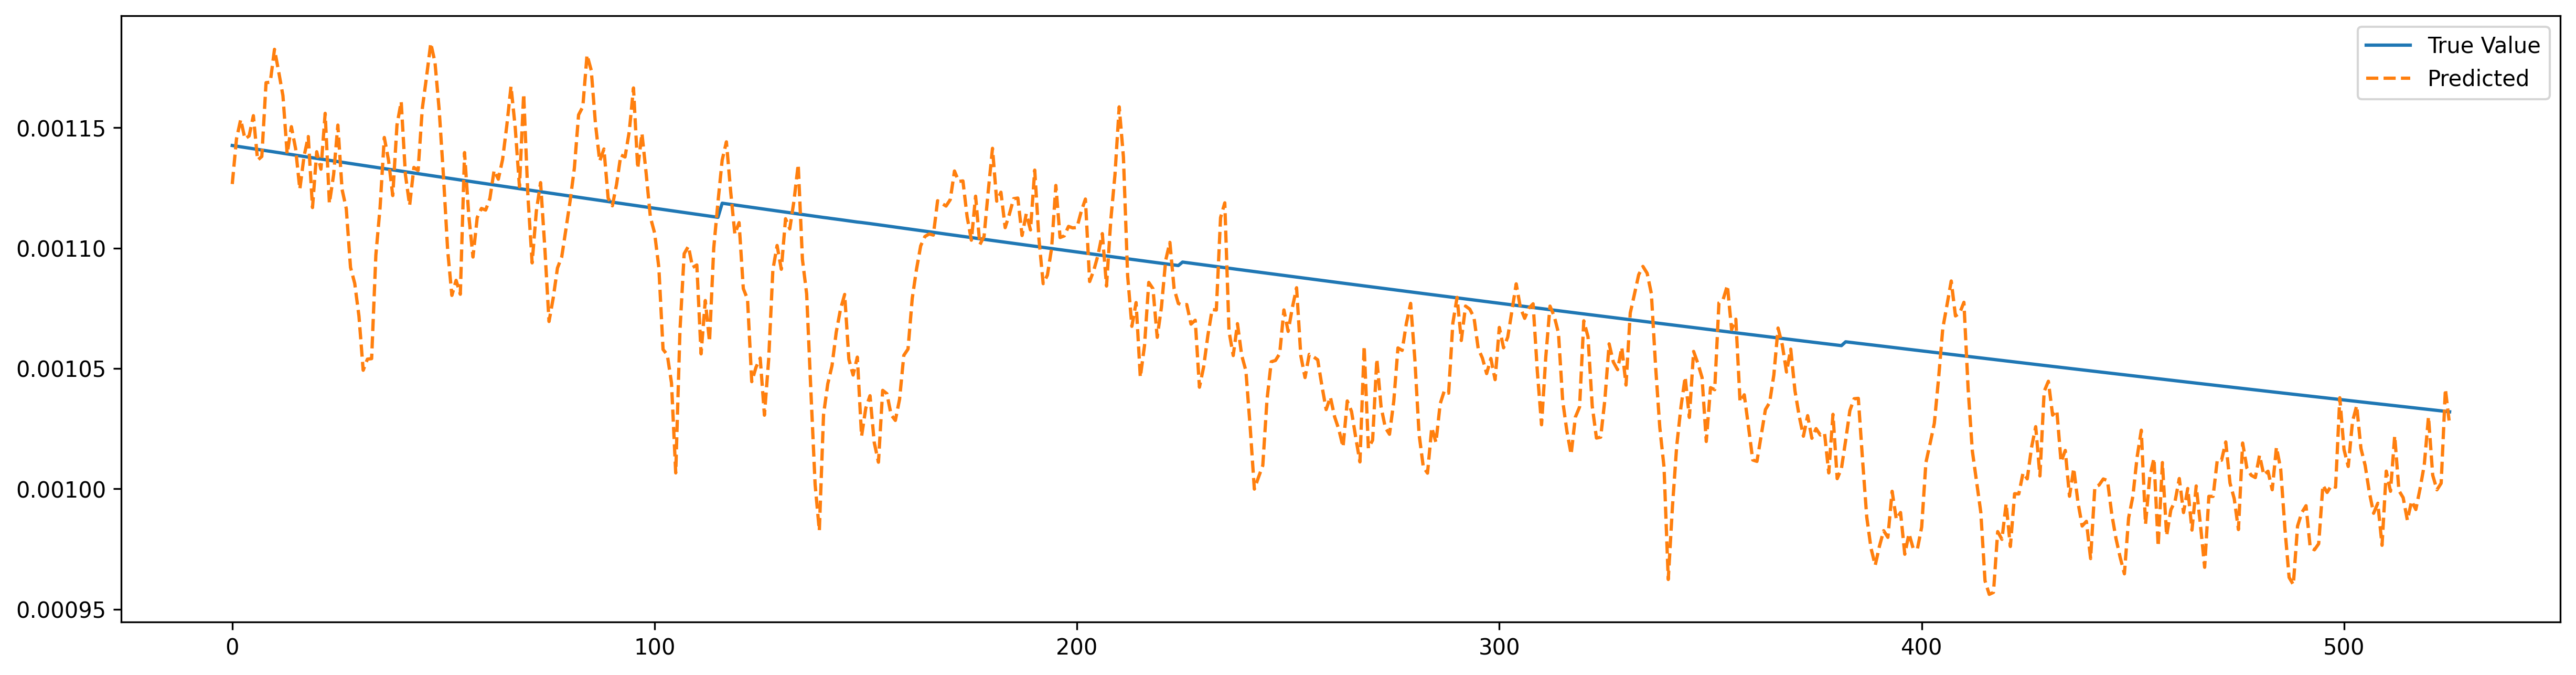

In [192]:
from sklearn.metrics import mean_absolute_error
pred = model.predict(X_test)
plt.figure(figsize=(20,5),dpi=300)
plt.plot(y_test,label='True Value')
plt.plot(pred,linestyle='--', label = 'Predicted')
plt.legend()
plt.show()

In [193]:
tb_mae = np.mean(np.abs(y_test - pred))
tb_mae

3.3710150785387723e-05

In [194]:
pd.DataFrame(pred).value_counts()

0.000956    1
0.001089    1
0.001087    1
0.001086    1
0.001086    1
           ..
0.001028    1
0.001027    1
0.001027    1
0.001027    1
0.001185    1
Length: 526, dtype: int64

66/66 [==============================] - 0s 5ms/step


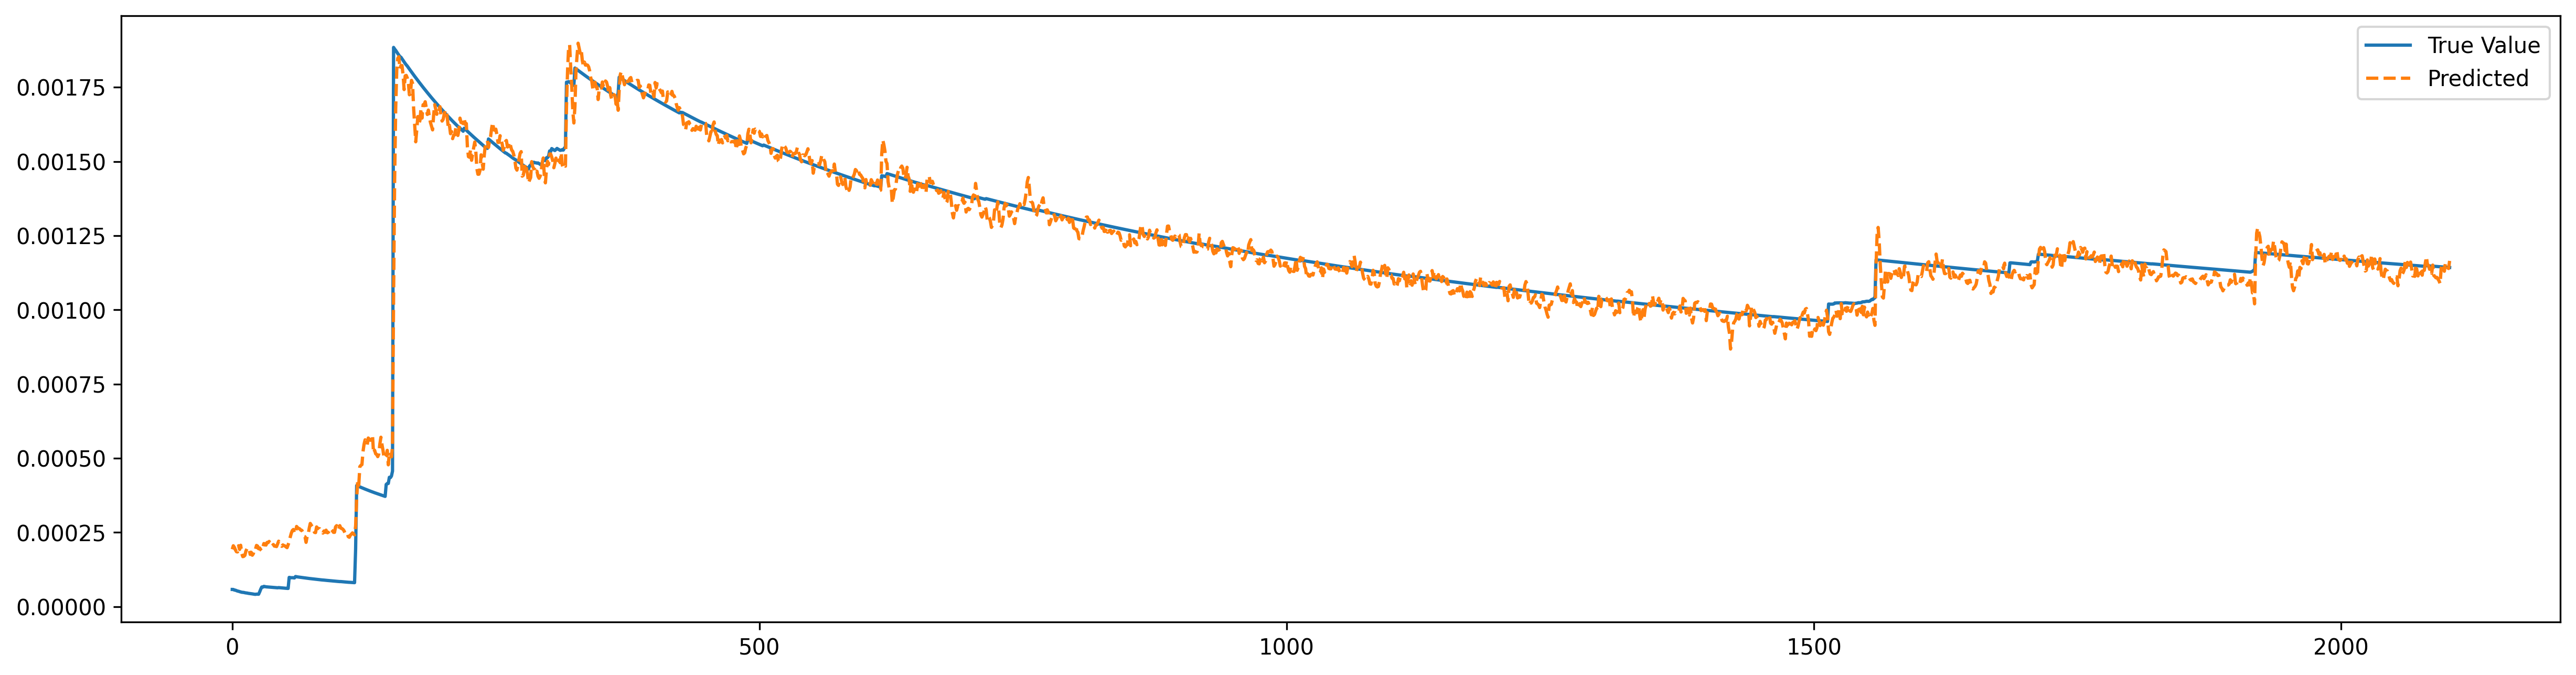

In [195]:
pred = model.predict(X_train)
plt.figure(figsize=(20,5),dpi=300)
plt.plot(y_train,label='True Value')
plt.plot(pred,linestyle='--', label = 'Predicted')
plt.legend()
plt.show()

In [196]:
model.evaluate(X_test, y_test)

17/17 [==============================] - 0s 6ms/step - loss: 1.7270e-09 - mape: 3.1229


[1.7269669028152634e-09, 3.1228623390197754]

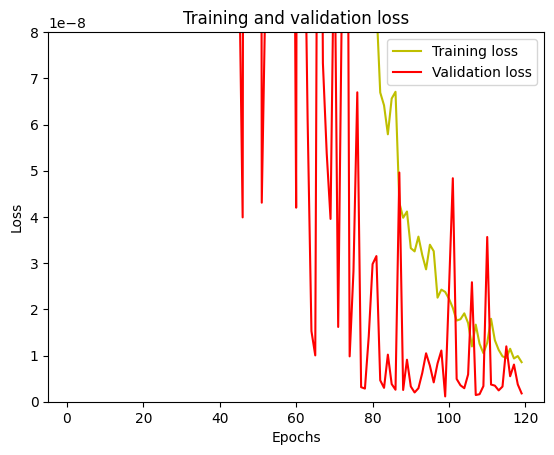

In [197]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0, 0.00000008)
plt.show()

# 0401 Sample with 20 bid/ask

In [21]:
data = pd.read_csv('/Users/yuhaoli/code/HowardLiYH/Volatility-prediction/datasets/raw/data_0401(6hrs).csv')
data

,2023-04-01 08:43:24,17729120410,28497.00000000,0.00176000,28496.76000000,0.00351000,28496.00000000,0.00176000.1,28495.28000000,0.43006000,...,28498.90000000,0.00045000,28498.98000000,0.02285000,28499.08000000,0.00178000,28499.39000000,0.00046000,28499.45000000,0.02612000
0,2023-04-01 08:43:29,17729121141,28492.26,0.00037,28492.00,0.00176,28491.11,0.00377,28491.00,0.00176,...,28496.44,0.78696,28496.45,0.47363,28496.46,0.82804,28496.74,0.01817,28496.96,0.01999
1,2023-04-01 08:43:34,17729121414,28492.00,0.02180,28491.93,0.08660,28491.11,0.00377,28491.00,0.00176,...,28495.26,0.02287,28496.42,0.03038,28496.43,0.53314,28496.44,0.78696,28496.45,0.47363
2,2023-04-01 08:43:38,17729121625,28490.55,0.70889,28490.54,0.91462,28490.00,0.00275,28489.85,0.06192,...,28495.17,0.05167,28495.22,0.08000,28495.23,0.05019,28495.26,0.02287,28496.42,0.03038
3,2023-04-01 08:43:43,17729121890,28490.00,1.89468,28489.97,0.60454,28489.84,0.10000,28489.83,0.24396,...,28495.12,0.01137,28495.17,0.05167,28495.22,0.08000,28495.23,0.05019,28495.26,0.02287
4,2023-04-01 08:43:47,17729122014,28490.00,1.77856,28489.84,0.10000,28489.83,0.24396,28489.65,0.00312,...,28495.00,0.02451,28495.01,0.02935,28495.12,0.01137,28495.17,0.05167,28495.22,0.08000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9168,2023-04-01 14:34:25,17730170833,28395.00,1.38557,28394.94,0.53725,28394.92,2.25094,28394.76,0.92475,...,28398.36,0.04990,28398.81,0.01092,28399.00,0.00039,28399.35,0.00618,28399.63,0.00070
9169,2023-04-01 14:34:29,17730170997,28395.00,1.38441,28394.94,0.53725,28394.92,2.25094,28394.75,0.01778,...,28398.18,0.00070,28398.36,0.04990,28398.81,0.01092,28399.00,0.00039,28399.35,0.00618
9170,2023-04-01 14:34:29,17730171006,28395.00,1.30573,28394.92,2.25094,28394.75,0.01778,28394.33,0.00081,...,28398.18,0.00070,28398.36,0.04990,28398.81,0.01092,28399.00,0.00039,28399.35,0.00618
9171,2023-04-01 14:34:34,17730171141,28395.00,1.67925,28394.92,1.17915,28394.33,0.00081,28393.80,0.61716,...,28398.18,0.00070,28398.36,0.04990,28398.81,0.01092,28399.00,0.00039,28399.35,0.00618


In [22]:
data.isnull().values.any()

False

In [23]:
columns_name = list(data1.columns)[:-2]

In [24]:
data = data.iloc[:,2:]

In [25]:
data

,28497.00000000,0.00176000,28496.76000000,0.00351000,28496.00000000,0.00176000.1,28495.28000000,0.43006000,28495.27000000,0.71669000,...,28498.90000000,0.00045000,28498.98000000,0.02285000,28499.08000000,0.00178000,28499.39000000,0.00046000,28499.45000000,0.02612000
0,28492.26,0.00037,28492.00,0.00176,28491.11,0.00377,28491.00,0.00176,28490.75,0.19738,...,28496.44,0.78696,28496.45,0.47363,28496.46,0.82804,28496.74,0.01817,28496.96,0.01999
1,28492.00,0.02180,28491.93,0.08660,28491.11,0.00377,28491.00,0.00176,28490.67,0.02518,...,28495.26,0.02287,28496.42,0.03038,28496.43,0.53314,28496.44,0.78696,28496.45,0.47363
2,28490.55,0.70889,28490.54,0.91462,28490.00,0.00275,28489.85,0.06192,28489.84,0.10000,...,28495.17,0.05167,28495.22,0.08000,28495.23,0.05019,28495.26,0.02287,28496.42,0.03038
3,28490.00,1.89468,28489.97,0.60454,28489.84,0.10000,28489.83,0.24396,28489.65,0.00312,...,28495.12,0.01137,28495.17,0.05167,28495.22,0.08000,28495.23,0.05019,28495.26,0.02287
4,28490.00,1.77856,28489.84,0.10000,28489.83,0.24396,28489.65,0.00312,28489.31,0.03686,...,28495.00,0.02451,28495.01,0.02935,28495.12,0.01137,28495.17,0.05167,28495.22,0.08000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9168,28395.00,1.38557,28394.94,0.53725,28394.92,2.25094,28394.76,0.92475,28394.33,0.00081,...,28398.36,0.04990,28398.81,0.01092,28399.00,0.00039,28399.35,0.00618,28399.63,0.00070
9169,28395.00,1.38441,28394.94,0.53725,28394.92,2.25094,28394.75,0.01778,28394.33,0.00081,...,28398.18,0.00070,28398.36,0.04990,28398.81,0.01092,28399.00,0.00039,28399.35,0.00618
9170,28395.00,1.30573,28394.92,2.25094,28394.75,0.01778,28394.33,0.00081,28393.85,0.00941,...,28398.18,0.00070,28398.36,0.04990,28398.81,0.01092,28399.00,0.00039,28399.35,0.00618
9171,28395.00,1.67925,28394.92,1.17915,28394.33,0.00081,28393.80,0.61716,28393.37,0.54553,...,28398.18,0.00070,28398.36,0.04990,28398.81,0.01092,28399.00,0.00039,28399.35,0.00618


In [26]:
data.columns = columns_name

In [27]:
# Weighted Average Price 
data['WAP'] = (data['bp_1']*data['bz_1']
               +data['bp_2']*data['bz_2']
               +data['ap_1']*data['az_1']
               +data['ap_2']*data['az_2'])/(data['bz_1']+
                                         data['bz_2']+
                                         data['az_1']+
                                         data['az_2'])

In [28]:
## Spread
data['spread'] = ((data['ap_1']/data['bp_1']) - 1)

In [29]:
## Log price

def log_price(list_stock_prices):
    return np.log(list_stock_prices)

data.insert(0, 'log_price', log_price(data['WAP']))

data['log_returns'] = data.log_price.diff()

In [30]:
## Realized Volatility
def realized_volatility():
    list_vol = []
    i = 0
    for i in data.index:
        x = np.std(data.log_returns.iloc[:i])
        i += 1
        list_vol.append(x)
    
    return list_vol

data['realized_volatility'] = realized_volatility()

In [133]:
## Previous volatility

data['volatility_t+1'] = data['realized_volatility'].shift(-1)


In [32]:
data = data.iloc[3:-1,:]

In [40]:
data = data.iloc[:,-5:]

In [57]:
d

,WAP,spread,log_returns,realized_volatility,volatility_t+1
3,28490.008547,3.510004e-07,-2.331490e-05,0.000012,0.000011
4,28490.008529,3.510004e-07,-6.388916e-10,0.000011,0.000017
5,28488.951433,3.510137e-07,-3.710478e-05,0.000017,0.000016
6,28488.909106,3.510137e-07,-1.485751e-06,0.000016,0.000018
7,28488.943606,3.510137e-07,1.210985e-06,0.000018,0.000018
...,...,...,...,...,...
9167,28394.998642,3.521747e-07,1.027610e-06,0.000039,0.000039
9168,28394.998642,3.521747e-07,0.000000e+00,0.000039,0.000039
9169,28394.998162,3.521747e-07,-1.691898e-08,0.000039,0.000039
9170,28394.970149,3.521747e-07,-9.865364e-07,0.000039,0.000039


In [42]:
y = np.expand_dims(data['realized_volatility'].values, 1)

In [43]:
X = data.drop('realized_volatility', axis=1)

In [44]:
scaler = MinMaxScaler().fit(X)
X_scaled = scaler.transform(X)
X_scaled.shape

(9169, 4)

In [45]:
y.shape

(9169, 1)

In [46]:
def convert2matrix(X_arr,Y_arr, look_back=1):
    X, Y =[], []
     #iterating thorough the data with window as look back
    for i in range(len(X_arr)-look_back):
        d=i+look_back 
        # extracting the X as features and target of n days and Y as   target at (n+1)th day
        X.append(np.hstack((X_arr[i:d],Y_arr[i:d])))
        Y.append(Y_arr[d])
        
    return np.array(X), np.array(Y)

In [47]:
X.shape, y.shape

((9169, 4), (9169, 1))

In [48]:
X_new, y_new = convert2matrix(X_scaled, y, 10)
X_new.shape, y_new.shape

((9159, 10, 5), (9159, 1))

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2, shuffle=False)

In [51]:
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(X_new.shape[1], X_new.shape[2])))
model.add(LSTM(128, return_sequences=False))
# model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(1))

# compile and fit the model
model.compile(loss='mse', optimizer=Adam(0.001), metrics=['mape'])

In [52]:
# pipe = Pipeline([('Imputer', SimpleImputer(strategy = 'mean')),
#             ('scaler', MinMaxScaler()),
#             # 'model', ARIMA(order=(2, 1, 3), trend='t')])
#             'model', model])
history = model.fit(X_train, y_train, epochs=500, batch_size=8, shuffle=True,
                    validation_split=0.2,
                    callbacks = 
                    [EarlyStopping(patience=20, verbose=1, restore_best_weights=True)])

Epoch 1/500


2023-04-02 22:39:06.530795: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


733/733 [==============================] - 8s 9ms/step - loss: 1.3207e-04 - mape: 9138.7090 - val_loss: 9.2306e-07 - val_mape: 2567.4661
Epoch 2/500
733/733 [==============================] - 7s 9ms/step - loss: 1.1847e-06 - mape: 2236.5371 - val_loss: 1.5348e-06 - val_mape: 3292.2622
Epoch 3/500
733/733 [==============================] - 6s 9ms/step - loss: 1.0800e-06 - mape: 2167.8367 - val_loss: 1.6270e-07 - val_mape: 919.0220
Epoch 4/500
733/733 [==============================] - 6s 9ms/step - loss: 3.8305e-06 - mape: 4073.5171 - val_loss: 3.5232e-07 - val_mape: 1264.7852
Epoch 5/500
733/733 [==============================] - 7s 9ms/step - loss: 3.0143e-06 - mape: 3646.3362 - val_loss: 1.3723e-07 - val_mape: 886.3789
Epoch 6/500
733/733 [==============================] - 7s 9ms/step - loss: 2.1560e-06 - mape: 3178.6589 - val_loss: 1.8390e-06 - val_mape: 3386.5198
Epoch 7/500
733/733 [==============================] - 7s 9ms/step - loss: 2.4720e-06 - mape: 2945.6868 - val_loss: 7.66

58/58 [==============================] - 1s 5ms/step


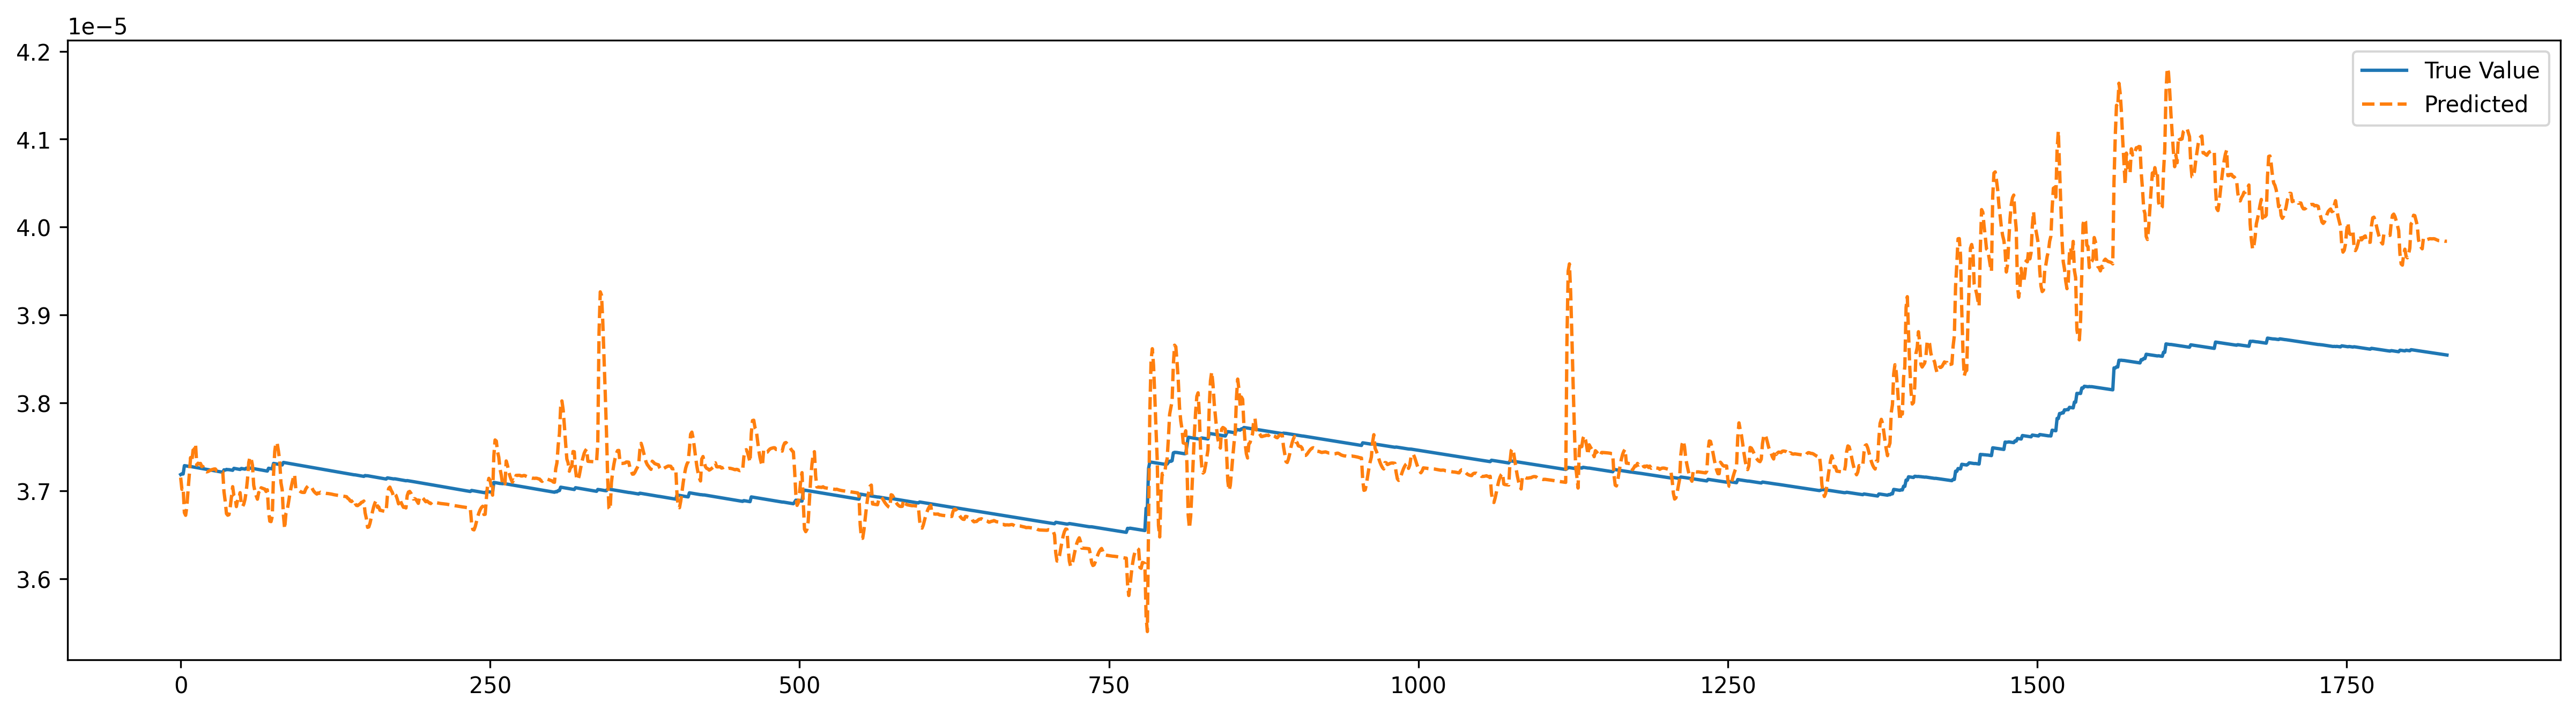

In [53]:
from sklearn.metrics import mean_absolute_error
pred = model.predict(X_test)
plt.figure(figsize=(20,5),dpi=300)
plt.plot(y_test,label='True Value')
plt.plot(pred,linestyle='--', label = 'Predicted')
plt.legend()
plt.show()

In [54]:
tb_mae = np.mean(np.abs(y_test - pred))
tb_mae

6.217395805575522e-07

In [55]:
pd.DataFrame(pred).value_counts()

0.000037    2
0.000038    2
0.000035    1
0.000037    1
0.000038    1
           ..
0.000037    1
0.000037    1
0.000037    1
0.000037    1
0.000042    1
Length: 1830, dtype: int64

229/229 [==============================] - 1s 6ms/step


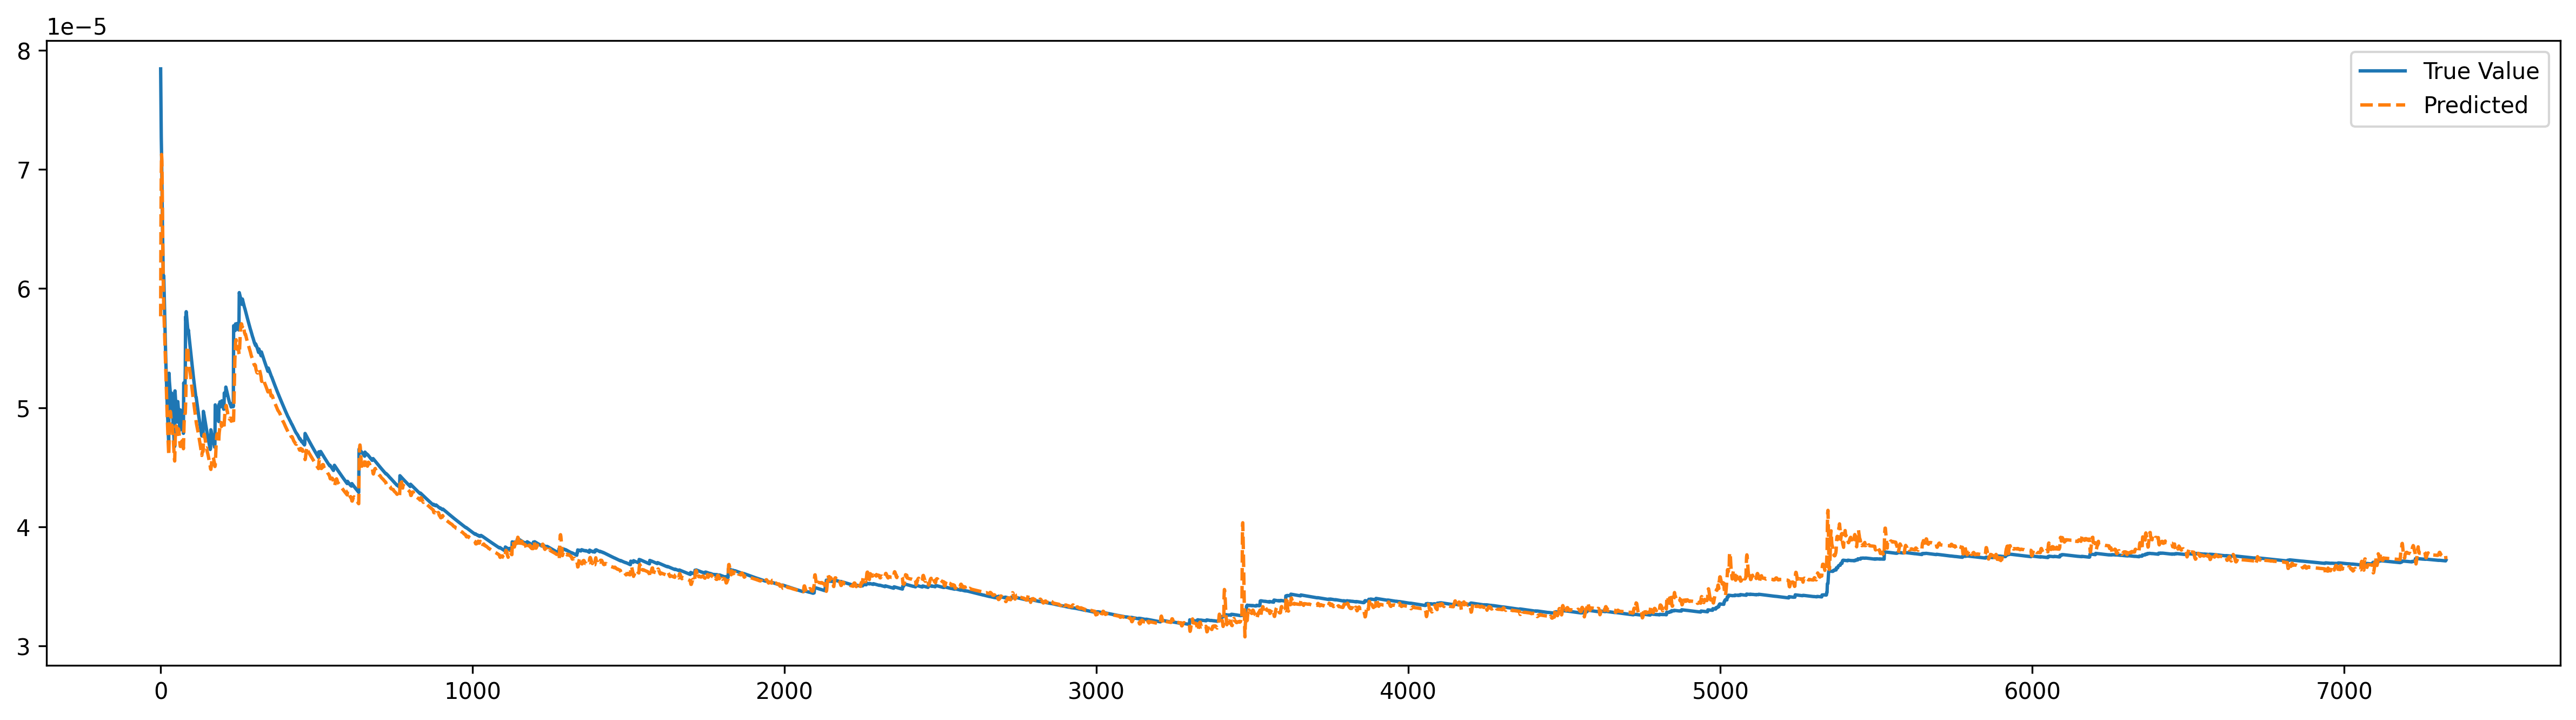

In [56]:
pred = model.predict(X_train)
plt.figure(figsize=(20,5),dpi=300)
plt.plot(y_train,label='True Value')
plt.plot(pred,linestyle='--', label = 'Predicted')
plt.legend()
plt.show()

In [58]:
model.evaluate(X_test, y_test)

58/58 [==============================] - 0s 6ms/step - loss: 9.0038e-13 - mape: 1.6436


[9.003795972684081e-13, 1.6436042785644531]

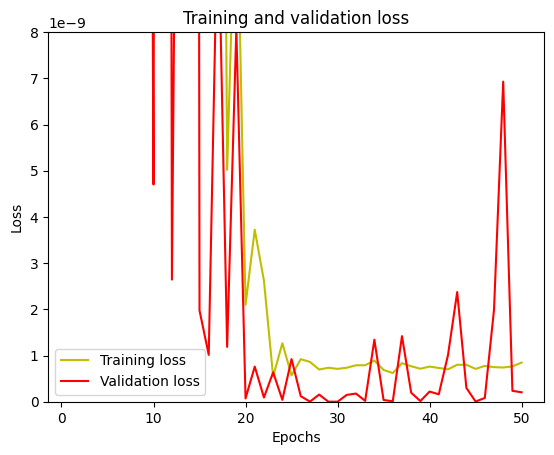

In [61]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0, 0.000000008)
plt.show()